# Import

In [1]:
# General Libraries
import pandas as pd
import numpy as np


# Data Visualization Libraries
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.font_manager as fm

# NLP Libraries
import re
from pythainlp.corpus.common import thai_words
from pythainlp.util import dict_trie
from pythainlp.corpus import thai_stopwords
import pythainlp
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)

# Ingestion

In [2]:
facebook_raw = pd.read_csv(r'dataset_facebook-comments--06-11_04-11-23-243 (1).csv')
print(facebook_raw.shape)

(785, 22)


<Axes: >

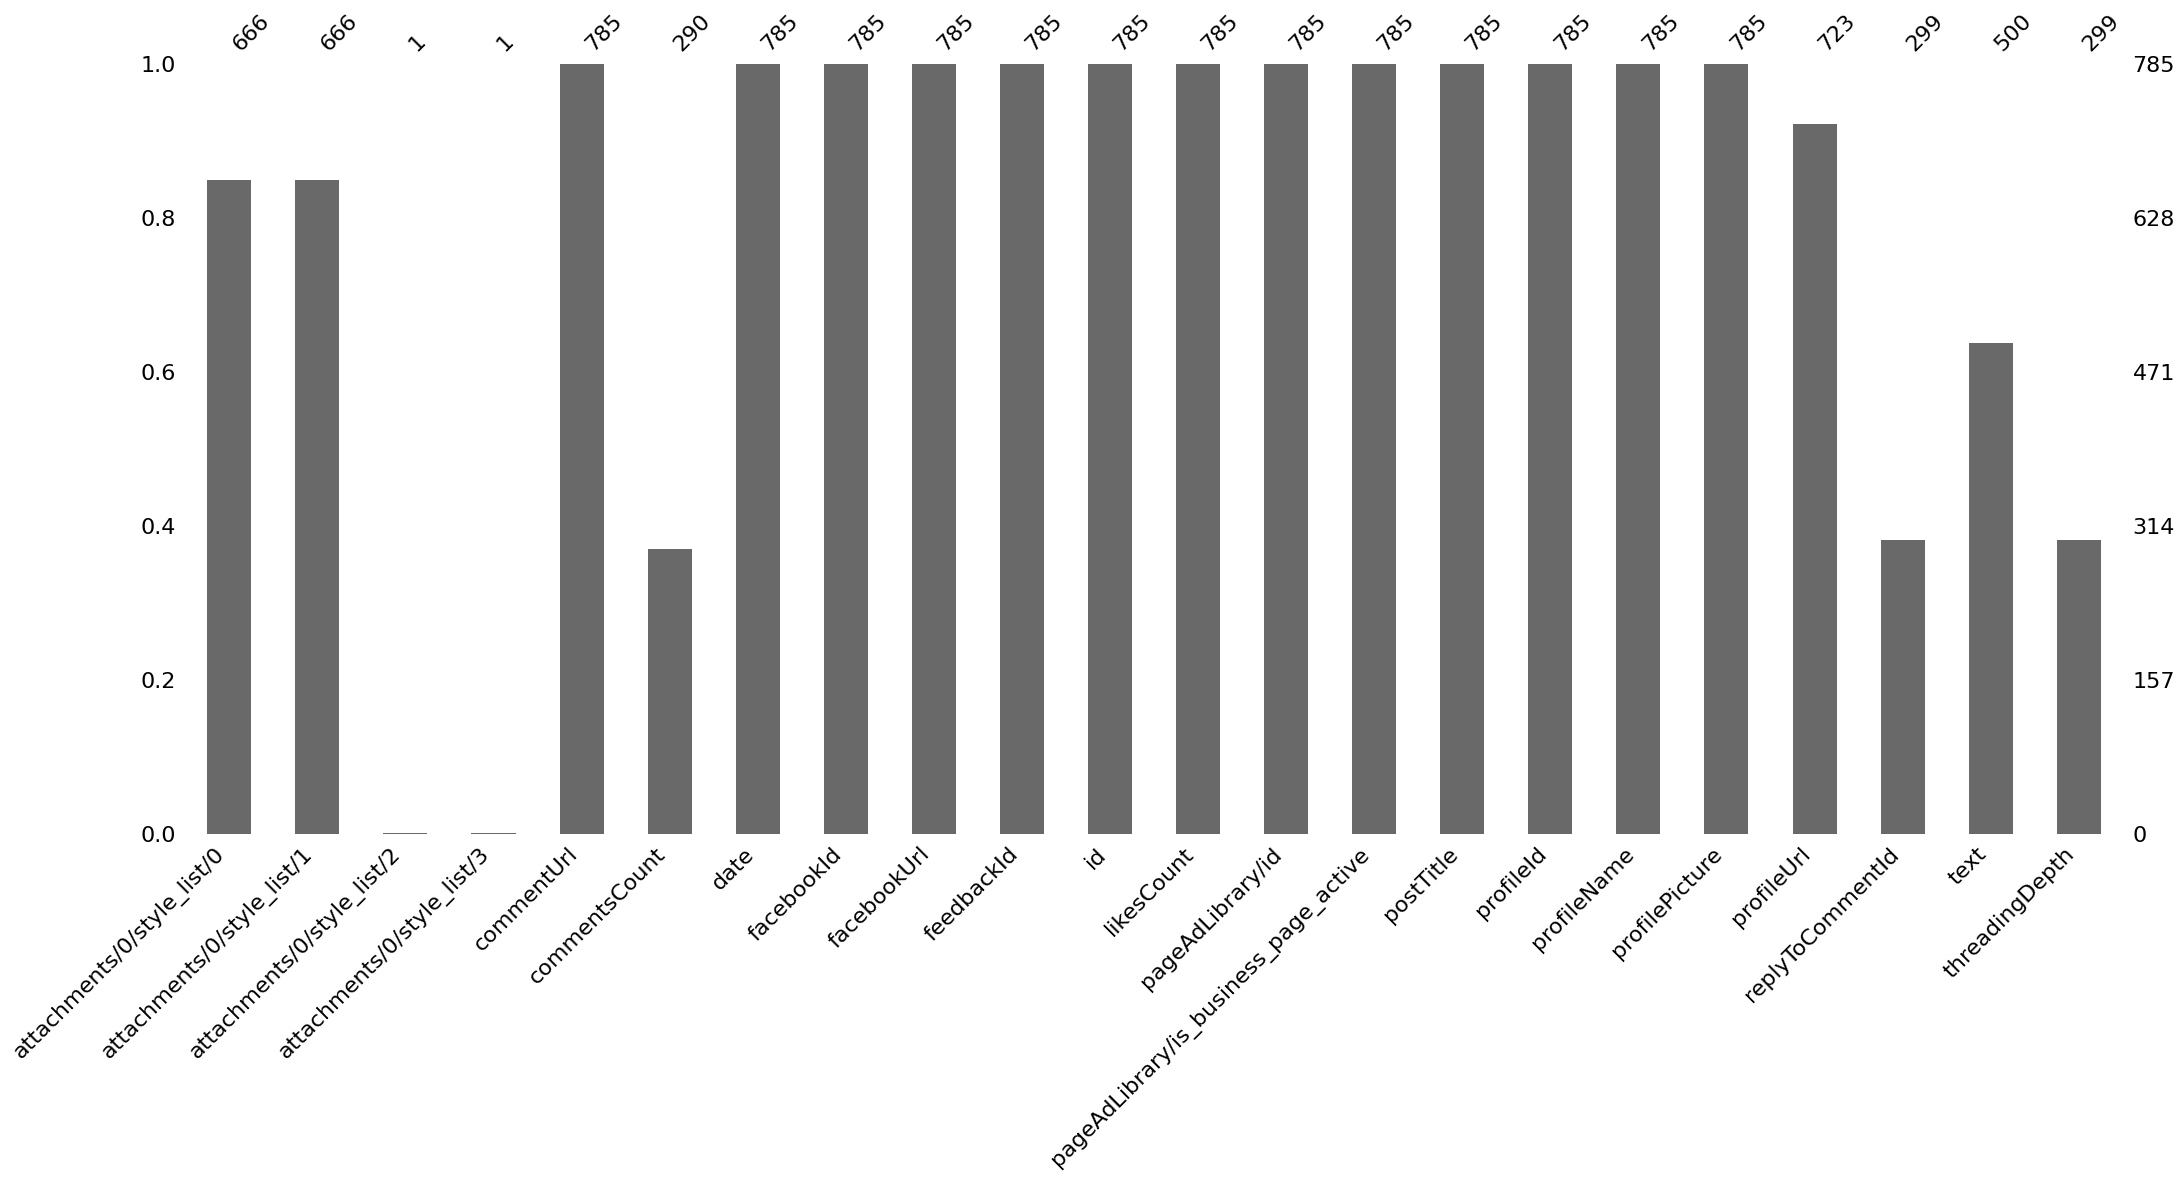

In [3]:
msno.bar(facebook_raw)

# EDA

## We can't see the distribution of date so we have to convert date to datetime object to visualize the 'date' distribution, this are still in EDA process

In [4]:
from datetime import datetime

def convert_date_and_time(column):
    # Convert date column to datetime
    facebook_raw[column] = pd.to_datetime(facebook_raw[column], format='%Y-%m-%dT%H:%M:%S.%fZ')
    
    # Extract date part and create a new column with dates only
    facebook_raw['date_only'] = facebook_raw[column].dt.date
    
    # Extract time part and create a new column with time only
    facebook_raw['timestamp'] = facebook_raw[column].dt.strftime('%H:%M:%S')
    
    return facebook_raw

In [5]:
facebook_raw = convert_date_and_time('date')

In [6]:
facebook_raw['date_only'].value_counts()

date_only
2024-06-10    185
2024-06-09    153
2024-06-02    127
2024-06-01     59
2024-06-08     53
2024-06-07     49
2024-06-03     37
2024-06-05     33
2024-06-06     26
2024-05-31     25
2024-06-04     24
2024-05-29      8
2024-05-30      6
Name: count, dtype: int64

In [7]:
facebook_raw['timestamp'].value_counts()

timestamp
14:35:13    2
13:02:02    2
09:12:55    1
21:44:32    1
15:40:01    1
           ..
07:25:08    1
10:51:40    1
08:09:21    1
08:00:50    1
21:35:26    1
Name: count, Length: 783, dtype: int64

In [8]:
# Drop the original date column
facebook_raw = facebook_raw.drop('date', axis=1)

facebook_raw.rename(columns={'date_only': 'date'}, inplace=True)

In [9]:
facebook_raw.head()

,attachments/0/style_list/0,attachments/0/style_list/1,attachments/0/style_list/2,attachments/0/style_list/3,commentUrl,commentsCount,facebookId,facebookUrl,feedbackId,id,likesCount,pageAdLibrary/id,pageAdLibrary/is_business_page_active,postTitle,profileId,profileName,profilePicture,profileUrl,replyToCommentId,text,threadingDepth,date,timestamp
0,photo,fallback,NaN,NaN,https://www.facebook.com/TOJONews/posts/pfbid0...,1.0,869328301881125,https://www.facebook.com/TOJONews/posts/pfbid0...,ZmVlZGJhY2s6ODY5MzI4MzAxODgxMTI1XzQzNDg4NzIwNj...,Y29tbWVudDo4NjkzMjgzMDE4ODExMjVfNDM0ODg3MjA2MD...,14,100663921489162,False,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,100064118881354,TOJO News,https://scontent.fdac31-1.fna.fbcdn.net/v/t39....,https://www.facebook.com/TOJONews,NaN,แอดมินใจดีใบ้เพิ่มให้ทุกคนนะคะ 🤭 มีใครทายถูกไห...,NaN,2024-06-05,09:12:55
1,video_inline,video,games_app,fallback,https://www.facebook.com/TOJONews/posts/pfbid0...,NaN,869328301881125,https://www.facebook.com/TOJONews/posts/pfbid0...,ZmVlZGJhY2s6ODY5MzI4MzAxODgxMTI1XzMwMjI2NDQ4Mj...,Y29tbWVudDo4NjkzMjgzMDE4ODExMjVfMzAyMjY0NDgyOT...,7,100663921489162,False,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,100064118881354,TOJO News,https://scontent.fdac31-1.fna.fbcdn.net/v/t39....,https://www.facebook.com/TOJONews,NaN,นับถอยหลัง 4 วัน แอดมินมีคำใบ้เพิ่มมาให้ทุกคนก...,NaN,2024-06-06,08:54:17
2,photo,fallback,NaN,NaN,https://www.facebook.com/TOJONews/posts/pfbid0...,1.0,869328301881125,https://www.facebook.com/TOJONews/posts/pfbid0...,ZmVlZGJhY2s6ODY5MzI4MzAxODgxMTI1XzExNTEzNjM5MT...,Y29tbWVudDo4NjkzMjgzMDE4ODExMjVfMTE1MTM2MzkxNj...,0,100663921489162,False,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,100000252273736,Daeng Kku,https://scontent.fdac31-1.fna.fbcdn.net/v/t39....,https://www.facebook.com/daeng.kku,NaN,ร่วมกิจกรรม\nโจอี้ ภูวศิษฐ์​ อนันต์พรสิริ\nDa...,NaN,2024-06-10,09:05:00
3,NaN,NaN,NaN,NaN,https://www.facebook.com/TOJONews/posts/pfbid0...,1.0,869328301881125,https://www.facebook.com/TOJONews/posts/pfbid0...,ZmVlZGJhY2s6ODY5MzI4MzAxODgxMTI1XzIxODU0OTMyMD...,Y29tbWVudDo4NjkzMjgzMDE4ODExMjVfMjE4NTQ5MzIwMT...,1,100663921489162,False,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,1220677411,Nu Earn Jieamjindarat,https://scontent.fdac31-2.fna.fbcdn.net/v/t39....,https://www.facebook.com/nuearn.jang,NaN,นุ๊ก ธนดล\nจันทร์เพ็ญ เพ็ญ Aou Kub Monvipa U-...,NaN,2024-05-30,09:30:41
4,NaN,NaN,NaN,NaN,https://www.facebook.com/TOJONews/posts/pfbid0...,NaN,869328301881125,https://www.facebook.com/TOJONews/posts/pfbid0...,ZmVlZGJhY2s6ODY5MzI4MzAxODgxMTI1Xzk5NjE2MTM5NT...,Y29tbWVudDo4NjkzMjgzMDE4ODExMjVfOTk2MTYxMzk1ND...,0,100663921489162,False,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,100000700855252,ดนุพงษ์ กลิ่นษร,https://scontent.fdac31-1.fna.fbcdn.net/v/t39....,https://www.facebook.com/aofjung2in1,NaN,อาร์ เดอะสตาร์ค่ะ (อาณัตพล ศิริชุมแสง) Amarit...,NaN,2024-05-30,13:36:49


/home/dr01/miniconda3/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


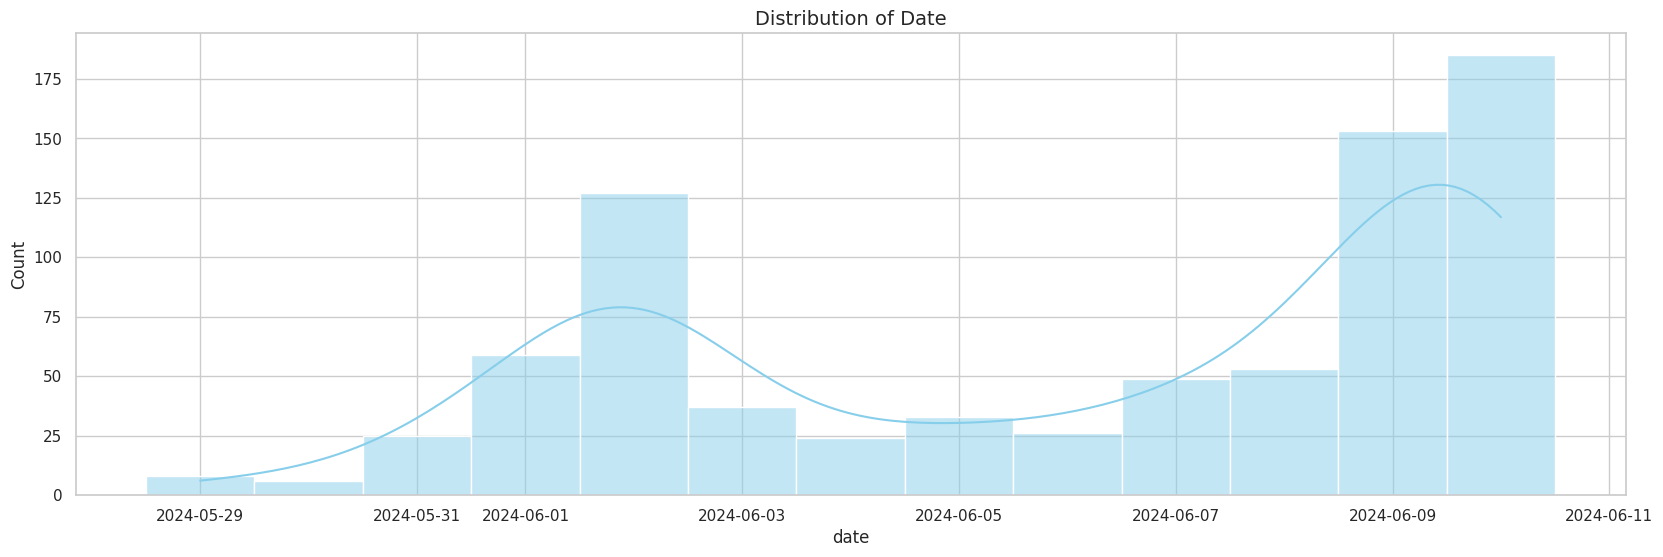

In [10]:
sns.set(style = 'whitegrid')

fig, ax = plt.subplots(1, 1, figsize = (20, 6))

sns.histplot(facebook_raw['date'], kde = True, color = 'skyblue', ax = ax)

#Set the title for each plot
ax.set_title('Distribution of Date', fontsize = 14)

plt.show()

In [11]:
facebook_raw['profileName'].value_counts()

profileName
Veerawat Tangsrad           5
สมศักดิ์ สินนิธิส           4
Ditthakron Nest             3
MiewOoz Jieranan            3
พิศิษฐ อินทรสังขนาวิน       3
                           ..
พูลศิริ สลักคำ              1
มาร์ค ผู้ค่ายักษ์           1
แตงหวาน ฟางแก้ว             1
Pim Nilrat                  1
นู๋ว์ ตุ้ยนุ้ย ปภาวรินท์    1
Name: count, Length: 485, dtype: int64

In [12]:
facebook_raw['profileName'].nunique()

485

# Oberservation


1. Source of the data are from the TOJO NEWS share campaign 
2. Data are range between 2024-05-29 - 2024-06-10 == 12 days 
3. There are total of 7xx comments
4. There are 485 Unique ProfileName
4. We will do only text analysis, will skip the part of image, attachment analysis


# Data Preprocessing

## Extract username

In [13]:
facebook_raw.columns

Index(['attachments/0/style_list/0', 'attachments/0/style_list/1',
       'attachments/0/style_list/2', 'attachments/0/style_list/3',
       'commentUrl', 'commentsCount', 'facebookId', 'facebookUrl',
       'feedbackId', 'id', 'likesCount', 'pageAdLibrary/id',
       'pageAdLibrary/is_business_page_active', 'postTitle', 'profileId',
       'profileName', 'profilePicture', 'profileUrl', 'replyToCommentId',
       'text', 'threadingDepth', 'date', 'timestamp'],
      dtype='object')

In [14]:
facebook_raw.profileUrl.value_counts()

profileUrl
https://www.facebook.com/people/Veerawat-Tangsrad/pfbid028qgiXsY1TjwmwVAboHS27A4PCYXyKxXyxzVYMXsyGrhRKjC27Yh5aubN7gGArcUvl/                                                                                                                                                                                           5
https://www.facebook.com/people/%E0%B8%AA%E0%B8%A1%E0%B8%A8%E0%B8%B1%E0%B8%81%E0%B8%94%E0%B8%B4%E0%B9%8C-%E0%B8%AA%E0%B8%B4%E0%B8%99%E0%B8%99%E0%B8%B4%E0%B8%98%E0%B8%B4%E0%B8%AA/pfbid0286YiKpR2kuQwdtTnTttW2oCErKQ7b65i3GRNmpDh9AmnKfaDzRCtx9AqdcNuuxyJl/                                                           4
https://www.facebook.com/kungza.hh                                                                                                                                                                                                                                                                                    3
https://www.facebook.com/aofjung2in1                 

In [15]:
#Extract username from profileUrl
facebook_raw['username'] = facebook_raw['profileUrl'].str.split('/').str[-1]

In [16]:
facebook_raw['username'].value_counts()

username
                           505
aofjung2in1                  3
ditthakron.nest.9            3
kantacha.kraisawad           3
kru.kla.5                    3
                          ... 
tonpaibook                   1
khnm.ru.67940                1
giftsawitreechaipaitoon      1
koy.tualek                   1
mam.mahaudom                 1
Name: count, Length: 142, dtype: int64

In [17]:
#Replace 'None' with NaN
facebook_raw['username'] = facebook_raw['username'].replace('None', np.nan)

In [18]:
facebook_raw.columns

Index(['attachments/0/style_list/0', 'attachments/0/style_list/1',
       'attachments/0/style_list/2', 'attachments/0/style_list/3',
       'commentUrl', 'commentsCount', 'facebookId', 'facebookUrl',
       'feedbackId', 'id', 'likesCount', 'pageAdLibrary/id',
       'pageAdLibrary/is_business_page_active', 'postTitle', 'profileId',
       'profileName', 'profilePicture', 'profileUrl', 'replyToCommentId',
       'text', 'threadingDepth', 'date', 'timestamp', 'username'],
      dtype='object')

In [19]:
facebook_raw.profileId.value_counts()

profileId
pfbid028qgiXsY1TjwmwVAboHS27A4PCYXyKxXyxzVYMXsyGrhRKjC27Yh5aubN7gGArcUvl    5
pfbid0286YiKpR2kuQwdtTnTttW2oCErKQ7b65i3GRNmpDh9AmnKfaDzRCtx9AqdcNuuxyJl    4
pfbid0U9RBu3jRU66zvzmNGgqf9xVLU29qnAoN9HeJCucLTXw2xTtbcbbaThTBy9KASgUNl     3
pfbid0yPT5RF8HD3Xvm71PuK2yqF4YDwGNQHtDCE5LqxpRk4QeJkRg2s4XFpGbDq9hqY5Ml     3
pfbid0uRzx9SRnhiSosXef1iKcm7L4DMLjrMdzHqovNPyNZ3ALKssuVuNsYgzHd24BQUrDl     3
                                                                           ..
pfbid0nfVtM3un98LZFshZkNeksbGWaRa7eMchWvMWLkkzWQytNyF4PhoZ2F8pxRKovTGEl     1
pfbid0FTLkMqBLRCRZ8xDA8sT5xZkiTrfHXTjrqEGER7fugspvKcr57b8YhCfT3g389dHzl     1
pfbid0BQ6uoHUni2djDoVNnvbDd5QM1yW9yqybSyYwkk6u51b5mui3inL7bqnhKdtMJrnVl     1
pfbid02WujiPLnQtArWpUxhSsaqXHJUyhJjMUFpLZye2GYV5Eb4Uqm7M6o8QMycE8XaBCyol    1
pfbid02DC52CEjAvUZEhp7vJEPsntJ4Wv1UNpZr7aH2xu1BVmTNWJsoSrP1Q3UY1BFnPXFdl    1
Name: count, Length: 485, dtype: int64

In [20]:
#Filtered facebook_raw to include only column we need for text analysis

#Lowercase all columns name
facebook_raw.columns = facebook_raw.columns.str.lower()

facebook = facebook_raw[['profileid', 'profilename', 'username', 'profileurl', 'text', 'posttitle', 'date', 'timestamp']]

In [21]:
facebook

,profileid,profilename,username,profileurl,text,posttitle,date,timestamp
0,100064118881354,TOJO News,TOJONews,https://www.facebook.com/TOJONews,แอดมินใจดีใบ้เพิ่มให้ทุกคนนะคะ 🤭 มีใครทายถูกไห...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-05,09:12:55
1,100064118881354,TOJO News,TOJONews,https://www.facebook.com/TOJONews,นับถอยหลัง 4 วัน แอดมินมีคำใบ้เพิ่มมาให้ทุกคนก...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-06,08:54:17
2,100000252273736,Daeng Kku,daeng.kku,https://www.facebook.com/daeng.kku,ร่วมกิจกรรม\nโจอี้ ภูวศิษฐ์​ อนันต์พรสิริ\nDa...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,09:05:00
3,1220677411,Nu Earn Jieamjindarat,nuearn.jang,https://www.facebook.com/nuearn.jang,นุ๊ก ธนดล\nจันทร์เพ็ญ เพ็ญ Aou Kub Monvipa U-...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,09:30:41
4,100000700855252,ดนุพงษ์ กลิ่นษร,aofjung2in1,https://www.facebook.com/aofjung2in1,อาร์ เดอะสตาร์ค่ะ (อาณัตพล ศิริชุมแสง) Amarit...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:36:49
...,...,...,...,...,...,...,...,...
780,100095146487102,มีเป้าหมาย รอดตายให้ผ่านวัน,,https://www.facebook.com/people/%E0%B8%A1%E0%B...,NaN,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-09,22:19:40
781,pfbid02LCDrqxb1XqVcqVpvxzmDAdYx1MEG6r8n8dFtzm6...,รุ่งรัสรา ประชาธนานุกิจ,NaN,NaN,NaN,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-02,12:29:46
782,pfbid0JsEKSJQ4TrWtGoGNiXgv4vsL4Lj5YPZKBTzZ1pvN...,Sazzy Kae,kaeya.chu,https://www.facebook.com/kaeya.chu,NaN,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-07,02:11:52
783,pfbid0RvmWxJeur7sMpW1P7f8dMawQgTm9hMpG2jyP8yzG...,ชาเนย ชญานุช,,https://www.facebook.com/people/%E0%B8%8A%E0%B...,NaN,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-09,22:13:49


In [22]:
#Exclude rows with missing text
facebook = facebook[facebook['text'].notna()]
facebook.shape

(500, 8)

In [23]:
#Exclude admin messages
facebook = facebook[facebook['username'] != 'TOJONews']

In [87]:
facebook.head()

,profileid,profilename,username,profileurl,text,posttitle,date,timestamp,mentions,ner_tag,cleaned_ner_tag,emoji,cleaned_text,tokens,cleaned_tokens
2,100000252273736,Daeng Kku,daeng.kku,https://www.facebook.com/daeng.kku,ร่วมกิจกรรมโจอี้ ภูวศิษฐ์​,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,09:05:00,"[Daeng, Noi, Kung, HomHuan, Mai, Sutapat]",[โจอี้ ภูวศิษฐ์],[โจอี้ภูวศิษฐ์],่ ิ ี ้ ู ิ ์ ​,ร่วมกิจกรรมโจอี้ภูวศิษฐ์​,"[ร่วม, กิจกรรม, โจ, อี้, ภูว, ศิษฐ์​]","[กิจกรรม, โจ, อี้, ภูว, ศิษฐ์​]"
3,1220677411,Nu Earn Jieamjindarat,nuearn.jang,https://www.facebook.com/nuearn.jang,นุ๊ก ธนดลจันทร์เพ็ญ เพ็ญ,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,09:30:41,"[Aou, Kub, Monvipa, U, domjit]","[น, ุ๊ก ธนดลจันทร์เพ็ญ เพ็ญ]","[น, ุ๊กธนดลจันทร์เพ็ญเพ็ญ]",ุ ๊ ั ์ ็ ็,นุ๊กธนดลจันทร์เพ็ญเพ็ญ,"[นุ๊กธนดล, จันทร์, เพ็ญ, เพ็ญ]","[นุ๊กธนดล, จันทร์, เพ็ญ, เพ็ญ]"
4,100000700855252,ดนุพงษ์ กลิ่นษร,aofjung2in1,https://www.facebook.com/aofjung2in1,อาร์ เดอะสตาร์ค่ะ (อาณัตพล ศิริชุมแสง) ดวงเดือ...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:36:49,"[Amarita, Ninploy, Boy, Chalermlarp]","[อาร์ เดอะสตาร์ , อาณัตพล ศิริชุมแสงดวงเดือน ข...","[อาร์เดอะสตาร์, อาณัตพลศิริชุมแสงดวงเดือนขัตติ...",์ ์ ่ ( ั ิ ิ ุ ) ื ั ิ ์,อาร์เดอะสตาร์ค่ะ(อาณัตพลศิริชุมแสง)ดวงเดือนขัต...,"[อาร์, เดอะสตาร์, ค่ะ, (, อา, ณัตพลศิ, ริ, ชุม...","[อาร์, เดอะสตาร์, (, อา, ณัตพลศิ, ริ, ชุมแสง, ..."
5,pfbid0cRiwUP4ESAwiMJZTpjf61qEe4qU9FkuiSwwX4s7k...,Sasiwimon Puachaisri,bowi.sasiwimom,https://www.facebook.com/bowi.sasiwimom,❤️ร่วมกิจกรรมค่ะ❤️ตอบ : ยุทธนา เปื้องกลาง หรือ...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,10:00:30,"[The, Star, Suwalak, Seangyong, Nongnamo, Jl, ...","[ยุทธนา เปื้องกลาง, ตูมตามรจนา แก่นจันทร์]","[ยุทธนาเปื้องกลาง, ตูมตามรจนาแก่นจันทร์]",❤ ️ ่ ิ ่ ❤ ️ : ุ ื ้ ื ู ✅ ่ ั ์ 🙏 🏻 ❤ ️,ร่วมกิจกรรมค่ะตอบ:ยุทธนาเปื้องกลางหรือตูมตามรจ...,"[ร่วม, กิจกรรม, ค่ะ, ตอบ, :, ยุทธนา, เปื้อง, ก...","[กิจกรรม, ตอบ, :, ยุทธนา, เปื้อง, กลาง, ตูมตาม..."
6,pfbid0286YiKpR2kuQwdtTnTttW2oCErKQ7b65i3GRNmpD...,สมศักดิ์ สินนิธิส,,https://www.facebook.com/people/%E0%B8%AA%E0%B...,"""โจอี้ ภูวศิษฐ์ อนันต์พรสิริ"" เดาล่ะ",📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:17:07,"[Boonrat, Srisukwang, Lookpla, Siritharakun, N...",[โจอี้ ภูวศิษฐ์ อนันต์พรสิริ],[โจอี้ภูวศิษฐ์อนันต์พรสิริ],""" ี ้ ู ิ ์ ั ์ ิ ิ "" ่","""โจอี้ภูวศิษฐ์อนันต์พรสิริ""เดาล่ะ","[""โจ, อี้, ภูว, ศิษฐ์, อนันต์, พร, สิริ, "", เด...","[""โจ, อี้, ภูว, ศิษฐ์, อนันต์, พร, สิริ, "", เด..."


In [25]:
facebook['text'].value_counts()

text
ร่วมกิจกรรมครับ\nคำตอบคือ=โจอี้ภูวิศิษฐ์อนันต์พรศิริ\nราณีแตงสาด\nวิชัยแตงสาด\nนายนาทภูมิ ไกรเพชร \nอุดรมาลา             4
ตูมตาม เดอะสตาร์ (ยุทธนา เปื้อนกลาง)\nPrincezz Errorz\nPornpen Piyavisuthikul\nBird Latphrao                             3
ร่วมกิจกรรม\nโจอี้ ภูวศิษฐ์​  อนันต์พรสิริ\nDaeng Noi\nKung HomHuan\nMai Sutapat                                         1
ตอบ    เขตต์ ศิรสิทธิ์ พันยา\nProgamp Km\nสุดเฮง แม่ปัด สุดปัง\nสุดเฮง สุดปัง                                            1
ชื่อศิลปิน เขตต์ ศิรสิทธิ์ พันยา\nซ้ำไป ซ้ำมา \nปลายทาง มุมมืด \nเซเว่นเอท ไนน์เท็น                                      1
                                                                                                                        ..
เขตต์ ศิรสิทธิ์ พันยา Anya Anya Pann Chatt Kook Kik                                                                      1
ตูมตาม ยุทธนา เปื้องกลาง\n(ตูมตาม เดอะสตาร์)\nWason Malapant\nเด็กสุพรรณเเล้วงัย หนักหัวคัยป่ะล่ะ\nSatid Satjavatakul    1
ตูมตาม ยุทธ

In [26]:
def extract_mentions(df):
    """ Extract mentions from text and create a new column with mentions only

    Args:
        df (DataFrame): a DataFrame to extract mentions from

    Returns:
        df: a DataFrame with mentions extracted
    """
    eng_pattern = r'[a-zA-Z]+'
    df['mentions'] = df['text'].str.findall(eng_pattern)
    
    return df

In [27]:
facebook = extract_mentions(facebook)

In [28]:
facebook.head()

,profileid,profilename,username,profileurl,text,posttitle,date,timestamp,mentions
2,100000252273736,Daeng Kku,daeng.kku,https://www.facebook.com/daeng.kku,ร่วมกิจกรรม\nโจอี้ ภูวศิษฐ์​ อนันต์พรสิริ\nDa...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,09:05:00,"[Daeng, Noi, Kung, HomHuan, Mai, Sutapat]"
3,1220677411,Nu Earn Jieamjindarat,nuearn.jang,https://www.facebook.com/nuearn.jang,นุ๊ก ธนดล\nจันทร์เพ็ญ เพ็ญ Aou Kub Monvipa U-...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,09:30:41,"[Aou, Kub, Monvipa, U, domjit]"
4,100000700855252,ดนุพงษ์ กลิ่นษร,aofjung2in1,https://www.facebook.com/aofjung2in1,อาร์ เดอะสตาร์ค่ะ (อาณัตพล ศิริชุมแสง) Amarit...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:36:49,"[Amarita, Ninploy, Boy, Chalermlarp]"
5,pfbid0cRiwUP4ESAwiMJZTpjf61qEe4qU9FkuiSwwX4s7k...,Sasiwimon Puachaisri,bowi.sasiwimom,https://www.facebook.com/bowi.sasiwimom,❤️ร่วมกิจกรรมค่ะ❤️\nตอบ : ยุทธนา เปื้องกลาง หร...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,10:00:30,"[The, Star, Suwalak, Seangyong, Nongnamo, Jl, ..."
6,pfbid0286YiKpR2kuQwdtTnTttW2oCErKQ7b65i3GRNmpD...,สมศักดิ์ สินนิธิส,,https://www.facebook.com/people/%E0%B8%AA%E0%B...,"""โจอี้ ภูวศิษฐ์ อนันต์พรสิริ"" เดาล่ะ \nBoonrat...",📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:17:07,"[Boonrat, Srisukwang, Lookpla, Siritharakun, N..."


In [29]:
#Replace \n 
facebook['text'] = facebook['text'].str.replace('\n', '')

In [30]:
# Delete English character from text
def remove_english_characters(df):
    """ Remove English characters from text

    Args:
        df (DataFrame): a DataFrame to remove English characters from

    Returns:
        df: a DataFrame with English characters removed
    """
    
    eng_pattern = r'[a-zA-Z]+'
    #Split text into words and remove words if it's an English character for character in words.
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if not any(re.match(eng_pattern, char) for char in word)]))
    
    return df

In [31]:
facebook = remove_english_characters(facebook)

In [32]:
facebook.head()

,profileid,profilename,username,profileurl,text,posttitle,date,timestamp,mentions
2,100000252273736,Daeng Kku,daeng.kku,https://www.facebook.com/daeng.kku,ร่วมกิจกรรมโจอี้ ภูวศิษฐ์​,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,09:05:00,"[Daeng, Noi, Kung, HomHuan, Mai, Sutapat]"
3,1220677411,Nu Earn Jieamjindarat,nuearn.jang,https://www.facebook.com/nuearn.jang,นุ๊ก ธนดลจันทร์เพ็ญ เพ็ญ,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,09:30:41,"[Aou, Kub, Monvipa, U, domjit]"
4,100000700855252,ดนุพงษ์ กลิ่นษร,aofjung2in1,https://www.facebook.com/aofjung2in1,อาร์ เดอะสตาร์ค่ะ (อาณัตพล ศิริชุมแสง) ดวงเดือ...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:36:49,"[Amarita, Ninploy, Boy, Chalermlarp]"
5,pfbid0cRiwUP4ESAwiMJZTpjf61qEe4qU9FkuiSwwX4s7k...,Sasiwimon Puachaisri,bowi.sasiwimom,https://www.facebook.com/bowi.sasiwimom,❤️ร่วมกิจกรรมค่ะ❤️ตอบ : ยุทธนา เปื้องกลาง หรือ...,📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-06-10,10:00:30,"[The, Star, Suwalak, Seangyong, Nongnamo, Jl, ..."
6,pfbid0286YiKpR2kuQwdtTnTttW2oCErKQ7b65i3GRNmpD...,สมศักดิ์ สินนิธิส,,https://www.facebook.com/people/%E0%B8%AA%E0%B...,"""โจอี้ ภูวศิษฐ์ อนันต์พรสิริ"" เดาล่ะ",📣 ทายเงาลุ้นเงิน ✨ กิจกรรมที่เปิดโอกาสให้สายสุ...,2024-05-30,13:17:07,"[Boonrat, Srisukwang, Lookpla, Siritharakun, N..."


In [33]:
# facebook.to_csv('/media/dr01/work/jovyan/work/Misc/Junior Lab/Fun project/facebook comment analysis/facebook_comment preprocessed for NER.csv', index = False)

## NER

In [34]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from pythainlp.tokenize import word_tokenize # pip install pythainlp
import torch

name="pythainlp/thainer-corpus-v2-base-model"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForTokenClassification.from_pretrained(name)

In [35]:
def fix_span_error(words,ner):
    _ner = []
    _ner=ner
    _new_tag=[]
    for i,j in zip(words,_ner):
        #print(i,j)
        i=tokenizer.decode(i)
        if i.isspace() and j.startswith("B-"):
            j="O"
        if i=='' or i=='<s>' or i=='</s>':
            continue
        if i=="<_>":
            i=" "
        _new_tag.append((i,j))
    return _new_tag

In [36]:
def extract_ner(text):
    cut=word_tokenize(text.replace(" ", "<_>"))
    inputs=tokenizer(cut,is_split_into_words=True,return_tensors="pt")

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    predictions = torch.argmax(logits, dim=2)
    predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]
    
    ner_tag=fix_span_error(inputs['input_ids'][0],predicted_token_class)
    
    return ner_tag

In [37]:
facebook['ner_tag'] = facebook['text'].apply(extract_ner)

In [38]:
facebook['ner_tag'].value_counts()

ner_tag
[(เขต, B-PERSON), (ต์, I-PERSON), ( , I-PERSON), (ศิร, I-PERSON), (สิทธิ์, I-PERSON)]                                                                                                                                                                                                                                                                                          27
[(โจ, B-PERSON), (อี้, I-PERSON), ( , I-PERSON), (ภูว, I-PERSON), (ศ, I-PERSON), (ิษฐ์, I-PERSON)]                                                                                                                                                                                                                                                                             14
[(ตูม, B-PERSON), (ตาม, I-PERSON), ( , I-PERSON), (เดอะสตาร์, I-PERSON), ( , O), ((, O), (ยุทธนา, O)]                                                                                                                                                       

In [39]:
#filtered ner_tag only B-PERSON and I-PERSON
facebook['ner_tag'] = facebook['ner_tag'].apply(lambda x: [tag for tag in x if tag[1] in ['B-PERSON', 'I-PERSON']])

In [40]:
facebook['ner_tag'].value_counts()

ner_tag
[(เขต, B-PERSON), (ต์, I-PERSON), ( , I-PERSON), (ศิร, I-PERSON), (สิทธิ์, I-PERSON)]                                                                                                                                                                                                                                                                                                                               53
[]                                                                                                                                                                                                                                                                                                                                                                                                                  25
[(ตูม, B-PERSON), (ตาม, I-PERSON), ( , I-PERSON), (ยุทธนา, I-PERSON)]                                                                                                             

In [41]:
#I assume that B-PERSON and I-PERSON are the same person, If there are more than 2 pairs it's mean that the text has more than 1 person
def concatenate_person_entities(tags):
    """ Concatenate person entities in a list of tags

    Args:
        tags (tuple): a tuple of tokens and tags

    Returns:
        list: a list of concatenated person entities
    """
    concatenated_persons = []
    current_entity = []
    identifier_tags = {'แม่', 'พี่', 'น้อง'}  

    try:
        for token, tag in tags:
            if tag == 'B-PERSON':
                if current_entity:
                    concatenated_persons.append(''.join(current_entity))
                current_entity = [token]
            elif tag == 'I-PERSON':
                current_entity.append(token)
            else:
                if current_entity:
                    concatenated_persons.append(''.join(current_entity))
                    current_entity = []
                concatenated_persons.append(token)
            #Use for handle if the text has identifier_tags, like พี่ปุ้ย, น้องเอ็ม we can concatenate them with the person name
            if token in identifier_tags:
                current_entity.append(token)
                
        if current_entity:
            concatenated_persons.append(''.join(current_entity))
            
    except (TypeError, ValueError, IndexError):
        # Handle cases where tags are not iterable, tuples are malformed, etc.
        return tags
    
    return concatenated_persons

In [42]:
# Apply the function to each row in the 'ner_tag' column
facebook['ner_tag'] = facebook['ner_tag'].apply(concatenate_person_entities)

In [43]:
facebook['ner_tag'].value_counts()

ner_tag
[เขตต์ ศิรสิทธิ์]                                                              53
[]                                                                             25
[ตูมตาม ยุทธนา]                                                                21
[โจอี้ ภูวศิษฐ์]                                                               16
[เขตต์ ศิรสิทธิ์ พันยา]                                                        14
                                                                               ..
[ตูมตาม ยุทธนา เปื้องกลาง, ตูมตาม เดอะสตาร์มงคล มงชัย จิรายุ ดอกบัว]            1
[เขตต์ ศิรสิทธิ์ พันยา, เรโทร เจอร์ซีย์]                                        1
[โจอี้ ภูวศิษฐ์ เอก ]                                                           1
[คุณเขตต์ ศิรสิทธิ์ พันยา , ปกป้อง เอื้อกูล , อสรยพ พานิช องครักษ์ มาดปทุม]     1
[เขตต์ ศิรสิทธิ์ พันยา, แม่แม่ปุ้ย, พี่พี่ตุ้ยนุ้ย, น้องน้องมิกกี้]             1
Name: count, Length: 307, dtype: int64

In [44]:
identifier_tags = ['แม่', 'พี่', 'น้อง', 'พ่อ']

def remove_first_identifier(tags, identifier_tags):
    """ Remove identifier tags from the tags

    Args:
        tags (tuple): a column containing tags

    Returns:
        tags: a column with identifier tags removed
    """
    new_tags = []
    for tag in tags:
        for identifier in identifier_tags:
            if identifier in tag:
                tag = tag.replace(identifier, '', 1)  # Remove only the first occurrence
                break
        new_tags.append(tag)
        
    return new_tags

In [45]:
facebook['cleaned_ner_tag'] = facebook['ner_tag'].apply(lambda x: remove_first_identifier(x, identifier_tags))

In [46]:
facebook['cleaned_ner_tag'].value_counts()

cleaned_ner_tag
[เขตต์ ศิรสิทธิ์]                                                              53
[]                                                                             25
[ตูมตาม ยุทธนา]                                                                21
[โจอี้ ภูวศิษฐ์]                                                               16
[เขตต์ ศิรสิทธิ์ พันยา]                                                        14
                                                                               ..
[ตูมตาม ยุทธนา เปื้องกลาง, ตูมตาม เดอะสตาร์มงคล มงชัย จิรายุ ดอกบัว]            1
[เขตต์ ศิรสิทธิ์ พันยา, เรโทร เจอร์ซีย์]                                        1
[โจอี้ ภูวศิษฐ์ เอก ]                                                           1
[คุณเขตต์ ศิรสิทธิ์ พันยา , ปกป้อง เอื้อกูล , อสรยพ พานิช องครักษ์ มาดปทุม]     1
[เขตต์ ศิรสิทธิ์ พันยา, แม่ปุ้ย, พี่ตุ้ยนุ้ย, น้องมิกกี้]                       1
Name: count, Length: 307, dtype: int64

In [47]:
facebook = facebook[facebook['cleaned_ner_tag'].apply(lambda x: len(x) >= 1)]

In [48]:
facebook['cleaned_ner_tag'] = facebook['cleaned_ner_tag'].apply(lambda x: [i.replace(' ', '').replace('"', '').replace('“', '') for i in x])

/tmp/ipykernel_2351220/1555424691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facebook['cleaned_ner_tag'] = facebook['cleaned_ner_tag'].apply(lambda x: [i.replace(' ', '').replace('"', '').replace('“', '') for i in x])


In [49]:
#Drop row where cleaned_ner_tag is ''
facebook = facebook[facebook['cleaned_ner_tag'].apply(lambda x: x[0] != '')]

In [50]:
# Extract emoji from text and create a new column with emoji only
facebook['emoji'] = facebook['text'].str.findall(r'[^\w\s,]').apply(lambda x: ' '.join(x))

# Create clenaed text column



In [51]:
def cleaned_text(df):
    #Remove whitespace from text and delete mention from text using mention column
    df['cleaned_text'] = df['text'].str.strip()
    df['cleaned_text'] = df['cleaned_text'].str.replace(' ', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'@\w+', '')
    return df

In [52]:
facebook = cleaned_text(facebook)

In [53]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese characters
                            u"\U00002702-\U000027B0"  # dingbats
                            u"\U00002702-\U000027B0"  # enclosed characters
                            u"\U000024C2-\U0001F251"  # enclosed characters
                            u"\U0001F910-\U0001F9E6"  # emoji supplement
                            u"\U0001F600-\U0001F636"  # emoticons
                            u"\U0001F681-\U0001F6C5"  # transport
                            u"\U0001F30D-\U0001F567"  # flags and countries
                            u"\U0001F900-\U0001F99D"  # supplemental symbols and pictographs
                            u"\U0001F9A0-\U0001F9FF"  # supplement
                            u"\U0001F1FA-\U0001F1FF"  # regional flags
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [54]:
facebook['cleaned_ner_tag'] = facebook['cleaned_ner_tag'].apply(lambda x: [remove_emojis(i) for i in x])

In [55]:
facebook['cleaned_text'] = facebook['cleaned_text'].apply(remove_emojis)

# Tokenization

In [56]:
# Trie & Dict for Thai Names
custom_dict_thai_name = set(thai_words())
updated_words = []
custom_dict_thai_name.update(updated_words)
trie = dict_trie(dict_source=custom_dict_thai_name)

In [57]:
facebook['tokens'] = facebook['cleaned_text'].apply(pythainlp.tokenize.word_tokenize, 
                                                    engine="newmm", # newmm using BertTokenizer
                                                    keep_whitespace=True,
                                                    custom_dict=trie
                                                    )

In [58]:
facebook['tokens'] = facebook['tokens'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else np.nan)

# Stopwords and Punctuation

In [59]:
facebook['tokens'] = facebook['tokens'].apply(lambda x: [i for i in x if not i.isdigit()] if isinstance(x, list) and len(x) > 0 else x)

In [60]:
# Remove Stopwords from the all_tokens column
stopwords = list(thai_stopwords()) 

other_words = []

other_words.extend(stopwords)
stopwords.extend(other_words)

facebook['cleaned_tokens'] = facebook['tokens'].apply(lambda x: [i for i in x if i not in stopwords] if isinstance(x, list) and len(x) > 0 else x)

In [61]:
facebook['cleaned_tokens']

2                        [กิจกรรม, โจ, อี้, ภูว, ศิษฐ์​]
3                         [นุ๊กธนดล, จันทร์, เพ็ญ, เพ็ญ]
4      [อาร์, เดอะสตาร์, (, อา, ณัตพลศิ, ริ, ชุมแสง, ...
5      [กิจกรรม, ตอบ, :, ยุทธนา, เปื้อง, กลาง, ตูมตาม...
6      ["โจ, อี้, ภูว, ศิษฐ์, อนันต์, พร, สิริ, ", เด...
                             ...                        
745                            [ตอบ, เขตต์, ศิร, สิทธิ์]
746                     [นู๋ว์, ตุ้ยนุ้ย, ป, ภาว, รินท์]
747    [ตอบ, เขตต์, ศิร, สิทธิ์, พัน, ยา, บุ๋ม, บุ๋ม,...
748    [โจ, อี้, ภูว, ศิษฐ์, อนันต์, พร, สิริ, มร, โศ...
749    [ตอบ, เขตต์, ศิร, สิทธิ์, พัน, ยา, แม่, ปุ้ย, ...
Name: cleaned_tokens, Length: 459, dtype: object

# Analysis

## Word counter

In [62]:
#Count most NER Tags which is most mentioned in the text
ner_counter = Counter(facebook['cleaned_ner_tag'].explode())

ner_counter.most_common()


[('เขตต์ศิรสิทธิ์', 78),
 ('ตูมตามยุทธนาเปื้องกลาง', 56),
 ('ตูมตามยุทธนา', 44),
 ('ตูมตามเดอะสตาร์', 34),
 ('ตูมตาม', 28),
 ('เขตต์ศิรสิทธิ์พันยา', 28),
 ('โจอี้ภูวศิษฐ์', 18),
 ('โจอี้ภูวศิษฐ์อนันต์พรสิริ', 12),
 ('ตูมตามยุทธนาเปื้อนกลาง', 7),
 ('ยุทธนา', 5),
 ('', 5),
 ('อาร์เดอะสตาร์', 4),
 ('ยุทธนาเปื้องกลาง', 4),
 ('โจอี้ภูวิศิษฐ์อนันต์พรศิริราณีแตงสาดวิชัยแตง', 4),
 ('นายนาทภูมิไกรเพชรอุดรมาลา', 4),
 ('ปิ่นมุก', 4),
 ('ภูวศิษฐ์อนันต์พรสิริ', 3),
 ('คุณเขตต์ศิรสิทธิ์พันยา', 3),
 ('กัสจัง', 3),
 ('นายวิชัย', 3),
 ('จูดี้', 3),
 ('ชินจังชินจัง', 3),
 ('เพลิงกัมปนาท', 3),
 ('ตาม่อน', 3),
 ('ตูมตามรจนาแก่นจันทร์', 2),
 ('.เขตต์ศิรสิทธิ์พันยา', 2),
 ('ตูมตามกันเกรียงไกร', 2),
 ('อิ่งอ้อยอรนุช', 2),
 ('ตูมตามโกสินทร์ก้านกระโทก', 2),
 ('ร็อคกี้', 2),
 ('พี่โฟกัส', 2),
 ('น้องกัญจน์', 2),
 ('สุธิดาโรจน์สัตตรัตน์', 2),
 ('อาร์อาณัตพล', 2),
 ('ธีระภัทร', 2),
 ('.', 2),
 ('แม่กระแต', 2),
 ('มหาเทพ', 2),
 ('มหาวายุโชคดีคําพา', 2),
 ('ตูมตามเดอะสตาร์ชนาธิปเจมส์อยู่วัฒนา', 2),
 ('โจอี้ภูวศิษฐ์

In [63]:
from wordcloud import WordCloud
import matplotlib.font_manager as fm

font_path = '/media/dr01/work/jovyan/work/Krungsri/Facebook Groups/SukhumvitSet.ttc'
prop = fm.FontProperties(fname=font_path)

def plot_wordcloud(counter):
    wordcloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110, background_color='white', font_path=font_path).generate_from_frequencies(counter)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


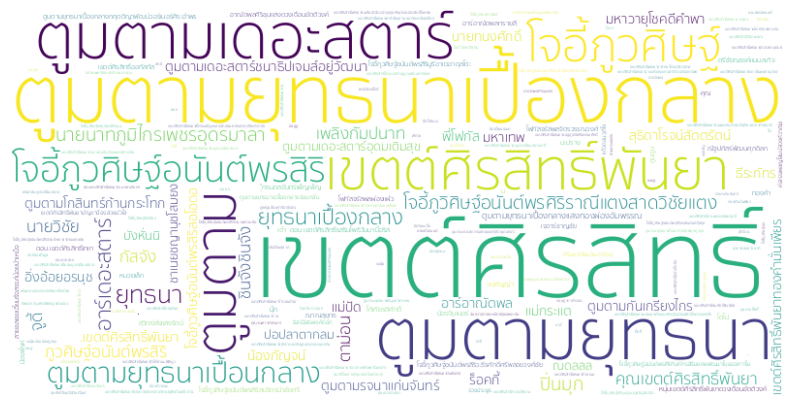

In [64]:
ner_counter = plot_wordcloud(ner_counter)

## TF-IDF

In [78]:
# Calculate tf-idf for all documents
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=1000)

tfidf.fit(facebook['cleaned_ner_tag'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else np.nan))

# Return most interested words
def get_top_words(text, tfidf, top_n=10):
    if isinstance(text, list) and len(text) > 0:
        X = tfidf.transform([text])
        sorted_items = np.argsort(X.toarray()).flatten()[::-1]
        feature_names = np.array(tfidf.get_feature_names_out())
        return feature_names[sorted_items][:top_n]
    else:
        return np.nan

/home/dr01/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [79]:
def get_top_words(text, tfidf, top_n=10):
    if isinstance(text, list) and len(text) > 0:
        X = tfidf.transform([text])
        sorted_items = np.argsort(X.toarray()).flatten()[::-1]
        feature_names = np.array(tfidf.get_feature_names_out())
        return {feature_names[i]: X.toarray().flatten()[i] for i in sorted_items[:top_n]}
    else:
        return np.nan

top_words = {}

for doc in facebook['cleaned_ner_tag']:
    words = get_top_words(doc, tfidf, top_n=20)
    if isinstance(words, dict):
        for k, v in words.items():
            if k in top_words:
                top_words[k] += v
            else:
                top_words[k] = v

In [80]:
#Remove where score is 1
top_words = {k: v for k, v in top_words.items() if v != 1}

In [81]:
#Only top 20 words
top_words = dict(sorted(top_words.items(), key=lambda x: x[1], reverse=True)[:20])

In [82]:
top_words

{'เขตต์ศิรสิทธิ์': 62.81139905787111,
 'ตูมตามยุทธนา': 32.392242648942954,
 'ตูมตามยุทธนาเปื้องกลาง': 30.790545517843867,
 'ตูมตามเดอะสตาร์': 24.512269152304018,
 'เขตต์ศิรสิทธิ์พันยา': 21.77804437265595,
 'ตูมตาม': 20.349520515247715,
 'โจอี้ภูวศิษฐ์': 17.41778789073481,
 'โจอี้ภูวศิษฐ์อนันต์พรสิริ': 10.554096721766902,
 'ตูมตามยุทธนาเปื้อนกลาง': 6.03652333308812,
 'ยุทธนา': 3.0812648140980543,
 'ภูวศิษฐ์อนันต์พรสิริ': 3.0,
 'ยุทธนาเปื้องกลาง': 2.8582901851985145,
 'โจอี้ภูวิศิษฐ์อนันต์พรศิริราณีแตงสาดวิชัยแตง': 2.8284271247461903,
 'นายนาทภูมิไกรเพชรอุดรมาลา': 2.8284271247461903,
 'อาร์เดอะสตาร์': 2.8206065470417925,
 '': 2.6999625413617263,
 'คุณเขตต์ศิรสิทธิ์พันยา': 2.533629073395337,
 'จูดี้': 2.2844955749307476,
 'เพลิงกัมปนาท': 2.28169540081136,
 'นายวิชัย': 2.132979342235344}

In [83]:
#remove '' from top_words
top_words = {k: v for k, v in top_words.items() if k != ''}

In [84]:
top_words

{'เขตต์ศิรสิทธิ์': 62.81139905787111,
 'ตูมตามยุทธนา': 32.392242648942954,
 'ตูมตามยุทธนาเปื้องกลาง': 30.790545517843867,
 'ตูมตามเดอะสตาร์': 24.512269152304018,
 'เขตต์ศิรสิทธิ์พันยา': 21.77804437265595,
 'ตูมตาม': 20.349520515247715,
 'โจอี้ภูวศิษฐ์': 17.41778789073481,
 'โจอี้ภูวศิษฐ์อนันต์พรสิริ': 10.554096721766902,
 'ตูมตามยุทธนาเปื้อนกลาง': 6.03652333308812,
 'ยุทธนา': 3.0812648140980543,
 'ภูวศิษฐ์อนันต์พรสิริ': 3.0,
 'ยุทธนาเปื้องกลาง': 2.8582901851985145,
 'โจอี้ภูวิศิษฐ์อนันต์พรศิริราณีแตงสาดวิชัยแตง': 2.8284271247461903,
 'นายนาทภูมิไกรเพชรอุดรมาลา': 2.8284271247461903,
 'อาร์เดอะสตาร์': 2.8206065470417925,
 'คุณเขตต์ศิรสิทธิ์พันยา': 2.533629073395337,
 'จูดี้': 2.2844955749307476,
 'เพลิงกัมปนาท': 2.28169540081136,
 'นายวิชัย': 2.132979342235344}

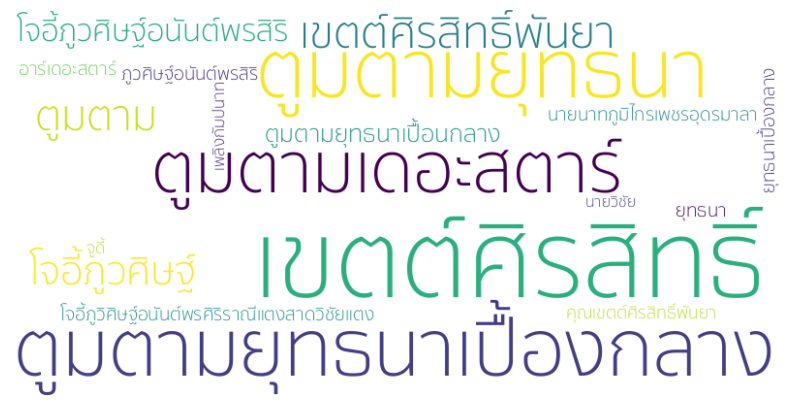

In [85]:
top_words = plot_wordcloud(top_words)

# Observation

This is a comment from facebook post campaign where the users need to guest whom are the unknow singer, if someone can guest right will get x Bath, This is the real data. I got this data set from scraping Facebook page comment for my colluge whose have to export comment to find the winner. So I just think what If I can do something with this data set, and I was right, I can do NLP things with this data set, I can:

1. Extract mentioned from comment
2. Do NER (Name Entity Recognition)
3. Do word counter, this seem produce some result but, TF-IDF are more accurate
4. Do TF-IDF which more accurate more than just count the occurance of words
5. Sadly I can't do topic modeling with this data set because it's a short text which have only mentioned facebook name
6. And time frame of this data is very short, shape of data after processed is only 459 rows with 15 columns
7. People guess right it's ตูมตาม The stars whom are the singer for this campaign

<b>Supplerk Petpon</b>